# Train an Xception Model from Keras with 2 Output Layers
**The output layers will classify an image into 2 different categories**

This script was motivated by:
- https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/ 
- https://www.kaggle.com/abnera/transfer-learning-keras-xception-cnn?scriptVersionId=818701

I wanted to show that it is possible to use the Xception model with multiple output layers to classify one image into 2 separate categories.

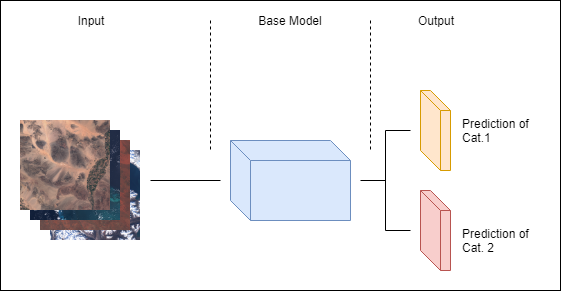

In [ ]:
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as k
from keras.utils import to_categorical

import matplotlib.pyplot as plt

## Settings

Run the following lines, if you want to use CPU only or ignore this if you don't have a GPU.

In [ ]:
config = tf.ConfigProto(allow_soft_placement=True, device_count = {'CPU' : 1, 'GPU' : 0})
session = tf.Session(config=config)
k.set_session(session)

- Set the paths to the images and to the model

In [ ]:
import os

# set the paths to the images and the model
data_dir = os.path.abspath("images/")
model_dir = os.path.abspath("model/model1/")

# create folders if they don't exist
os.makedirs(os.path.abspath('preview/'), exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

## Hyper Parameters

In [ ]:
# fix seed for reproducible results (only works on CPU, not GPU)
seed = 9
np.random.seed(seed=seed)
tf.set_random_seed(seed=seed)

img_width, img_height = 299, 299  # change based on the shape/structure of your images

# hyper parameters for model
based_model_last_block_layer_number = 126  # value is based on based model selected.
batch_size = 32  # try 4, 8, 16, 32, 64, 128, 256 dependent on CPU/GPU memory capacity (powers of 2 values).
nb_epoch = 50  # number of iteration the algorithm gets trained.
np_classes = 4 # number of classes the algorithm uses
learn_rate = 1e-4  # sgd learning rate
momentum = .9  # sgd momentum to avoid local minimum
transformation_ratio = .05  # how aggressive will be the data augmentation/transformation

## Gather Image Paths

**Important Note: the filename needs to contain cat1 and cat2 in order to be able to train the model**
- Search for png images in the given directory and the subdirectories within and return a list of file paths
- Set a random seed first to reproduce the results
- Shuffle the list of file paths

In [ ]:
import glob # pip install glob
import random

print("[INFO] Searching Images...")
imagePaths = glob.glob(data_dir + '/**/*.png', recursive=True)
random.seed(seed)
random.shuffle(imagePaths)
print(len(imagePaths))

## Populate Label- and Datalist

- Loop through the list of file paths
- split the file name into cat1 and cat2
- open the image, then resize it to the specified image size of the model
- transfer the image to a numpy array and add it to the list of images

In [ ]:
import cv2 # pip install opencv-python

print("[INFO] Gathering data and labels")

labelsCat1 = [] 
labelsCat2 = [] 
imageDataList = []

counter = 0
for files in imagePaths:
    # progress counter
    if (counter + 1) % 100 == 0:
        print(counter + 1, "/", len(imagePaths))
    
    # split the filename into category 1 and 2, ignore the filenumber
    filename = files.split(os.path.sep)[-1]
    
    categories = filename.split("_")
    (cat1, cat2, _) = categories
    
    # add the categories to the lists
    labelsCat1.append(cat1)
    labelsCat2.append(cat2)

    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(files)
    image = cv2.resize(image, (img_width, img_height))
    image = img_to_array(image)
    imageDataList.append(image)
    
    counter += 1

## Transform Image Data

- normalise the image by dividing every RGB pixel value with 255 to achieve a value between 0 and 1

In [ ]:
import numpy as np

print("[INFO] Transform the Data")
# scale the raw pixel intensities to the range [0, 1] and convert to a NumPy array
imageData = np.array(imageDataList, dtype="float") / 255.
print("[INFO] data matrix: {} images ({:.2f}MB)".format(
    len(imagePaths), imageData.nbytes / (1024 * 1000.0)))

## Preprocess Label Data

- transform the labels to a binary form so the model can process them
- **Remember that the Binarizer is sorting the labels alphabetically**

In [ ]:
from sklearn.preprocessing import LabelBinarizer

# binarize both sets of labels
print("[INFO] binarizing labels...")

# create numpy arrays from labels
labelsCat1 = np.array(labelsCat1)
labelsCat2 = np.array(labelsCat2)

# initialize the binarizer to transform the labels from str to binary representation
binarizer = LabelBinarizer()

# labelsCat1 needs to be transformed into categorical representation because it only contains 1 values 
# which will be translated into 0 and 1
# the fit_transform function translates them into an array of shape (,1)
# one column creates troubles when the loss function is set to categorical
# change the loss function or translate the labels to a categorical representation to solve this problem
labelsCat1 = binarizer.fit_transform(labelsCat1)
labelsCat1 = to_categorical(labelsCat1)

# labelsCat2 does not need to be translated into categorical representation because it contains more than 2 values
# calling the fit_transform function translates them into an array of shape (,4)
# this does not create problems in combination with the categorical loss function
labelsCat2 = binarizer.fit_transform(labelsCat2)

# uncomment following line, if you need to sort the columns differently to read them better afterwards
# the labelsCat2 columns need to be sorted differently
# np.argsort([1,2,0,3]) means that the column gets moved to another position like:
# column old - new
#         0  -  1
#         1  -  2
#         2  -  0
#         3  -  3
# labelsCat2 = labelsCat2[:,np.argsort([1,2,0,3])]

#print out labels and image
index = 0

# in my case it looked like this:
# [1. 0.] represents cat1 a
# [0. 1.] represents cat1 b
print(labelsCat1[index])

# in my case it looked like this:
# [1 0 0 0] represents cat2 a
# [0 1 0 0] represents cat2 b
# [0 0 1 0] represents cat2 c
# [0 0 0 1] represents cat2 d
print(labelsCat2[index])

# plot image
plt.imshow(imageData[index])

## Split Labels and Data

In [ ]:
from sklearn.model_selection import train_test_split

print("[INFO] Split dataset into train and validation...")
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(imageData, labelsCat1, labelsCat2,
    test_size=0.2, random_state=seed)
(trainX, testX, trainCat1Y, testCat1Y, trainCat2Y, testCat2Y) = split

# print length of training and test set
print(len(trainX), len(testX))

## Create Model

- Create the base model
- load the base model with pretrained weights of imagenet
- don't include the top layer because we want to create our own top layer
- create two output layers with labelsCat1.shape[-1] and labelsCat2.shape[-1] output nodes respectively
- _in my case it was 2 + 4 nodes for cat1 and cat2 respectively_
- **With 2 output layers, val_acc can not be monitored in the callbacks it has to be changed to val_loss**

In [ ]:
# Pre-Trained CNN Model using imagenet dataset for pre-trained weights
base_model = Xception(input_shape=(img_width, img_height, 3), weights='imagenet', include_top=False)

# Top Model Block
x = base_model.output
x = GlobalAveragePooling2D()(x)

# add the first output layer (2 nodes)
output_cat_1 = Dense(labelsCat1.shape[-1], activation='softmax', name='output_cat_1')(x)

# add the second output layer (4 nodes)
output_cat_2 = Dense(labelsCat2.shape[-1], activation='softmax', name='output_cat_2')(x)


# add your top layer(s) block to your base model
model = Model(inputs=base_model.input, outputs=[output_cat_1, output_cat_2])
print(model.summary())

# # let's visualize layer names and layer indices to see how many layers/blocks to re-train
# # uncomment when choosing based_model_last_block_layer
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all layers of the based model that is already pre-trained.
for layer in base_model.layers:
    layer.trainable = False

# add two loss functions for each output layer separate
model.compile(optimizer='nadam',
              loss={"output_cat_1": "categorical_crossentropy", "output_cat_2": "categorical_crossentropy"},
              metrics=['accuracy'])

# save weights of best training epoch: monitor either val_loss or val_acc

top_weights_path = os.path.join(os.path.abspath(model_dir), 'top_model_weights.h5')
callbacks_list = [
    ModelCheckpoint(top_weights_path, monitor="val_loss", verbose=1, save_best_only=True),
    EarlyStopping(monitor="val_loss", patience=10, verbose=0),
]

## Training

In [ ]:
print("\nStart Training Model\n")
# Train Simple CNN
# Sequential Mode
model.fit(trainX,
        {"output_cat_1": trainCat1Y, "output_cat_2": trainCat2Y},
        validation_data=(testX,
                        {"output_cat_1": testCat1Y, "output_cat_2": testCat2Y}),
        epochs=nb_epoch,
        callbacks=callbacks_list)

## Fine Tuning

- Load the weights for the model with two output layers to perform the fine tuning of the model
- Freeze all layers except the last 2 layers of the model

In [ ]:
# add the best weights from the train top model
# at this point we have the pre-train weights of the base model and the trained weight of the new/added top model
# we re-load model weights to ensure the best epoch is selected and not the last one.
model.load_weights(top_weights_path)

# based_model_last_block_layer_number points to the layer in your model you want to train.
# For example if you want to train the last block of a 19 layer VGG16 model this should be 15
# If you want to train the last Two blocks of an Inception model it should be 172
# layers before this number will used the pre-trained weights, layers above and including this number
# will be re-trained based on the new data.
for layer in model.layers[:based_model_last_block_layer_number]:
    layer.trainable = False
for layer in model.layers[based_model_last_block_layer_number:]:
    layer.trainable = True

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.


model.compile(optimizer='nadam',
              loss={"output_cat_1": "categorical_crossentropy", "output_cat_2": "categorical_crossentropy"},
              metrics=['accuracy'])

# save weights of best training epoch: monitor either val_loss or val_acc
final_weights_path = os.path.join(os.path.abspath(model_dir), 'model_weights.h5')
callbacks_list = [
    ModelCheckpoint(final_weights_path, monitor='val_loss', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10, verbose=0)
]

- Start fine tune for two output layers

In [ ]:
print("\nStart Fine Tuning Model\n")
# Fine Tune Model
# Sequential Mode
model.fit(trainX,
        {"output_cat_1": trainCat1Y, "output_cat_2": trainCat2Y},
        validation_data=(testX,
                        {"output_cat_1": testCat1Y, "output_cat_2": testCat2Y}),
        epochs=nb_epoch,
        callbacks=callbacks_list)

## Prediction

In [ ]:
probabilities = model.predict(testX, verbose=1)

In [ ]:
print(probabilities)

# Save Model To JSON

In [ ]:
# save the model
model_json = model.to_json()
with open(os.path.join(os.path.abspath(model_dir), 'model.json'), 'w') as json_file:
    json_file.write(model_json)

# Release Memory

In [ ]:
# release memory
k.clear_session()